In [1]:
import numpy as np
import albumentations as A
import json
import matplotlib.pyplot as plt
from PIL import Image

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
import os.path as osp
import math
import json
from PIL import Image

import torch
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset
from shapely.geometry import Polygon
from numba import njit

@njit
def cal_distance(x1, y1, x2, y2):
    '''calculate the Euclidean distance'''
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

@njit
def move_points(vertices, index1, index2, r, coef):
    '''move the two points to shrink edge
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        index1  : offset of point1
        index2  : offset of point2
        r       : [r1, r2, r3, r4] in paper
        coef    : shrink ratio in paper
    Output:
        vertices: vertices where one edge has been shinked
    '''
    index1 = index1 % 4
    index2 = index2 % 4
    x1_index = index1 * 2 + 0
    y1_index = index1 * 2 + 1
    x2_index = index2 * 2 + 0
    y2_index = index2 * 2 + 1

    r1 = r[index1]
    r2 = r[index2]
    length_x = vertices[x1_index] - vertices[x2_index]
    length_y = vertices[y1_index] - vertices[y2_index]
    length = cal_distance(vertices[x1_index], vertices[y1_index], vertices[x2_index], vertices[y2_index])
    if length > 1:
        ratio = (r1 * coef) / length
        vertices[x1_index] += ratio * (-length_x)
        vertices[y1_index] += ratio * (-length_y)
        ratio = (r2 * coef) / length
        vertices[x2_index] += ratio * length_x
        vertices[y2_index] += ratio * length_y
    return vertices

@njit
def shrink_poly(vertices, coef=0.3):
    '''shrink the text region
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        coef    : shrink ratio in paper
    Output:
        v       : vertices of shrinked text region <numpy.ndarray, (8,)>
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    r1 = min(cal_distance(x1,y1,x2,y2), cal_distance(x1,y1,x4,y4))
    r2 = min(cal_distance(x2,y2,x1,y1), cal_distance(x2,y2,x3,y3))
    r3 = min(cal_distance(x3,y3,x2,y2), cal_distance(x3,y3,x4,y4))
    r4 = min(cal_distance(x4,y4,x1,y1), cal_distance(x4,y4,x3,y3))
    r = [r1, r2, r3, r4]

    # obtain offset to perform move_points() automatically
    if cal_distance(x1,y1,x2,y2) + cal_distance(x3,y3,x4,y4) > \
       cal_distance(x2,y2,x3,y3) + cal_distance(x1,y1,x4,y4):
        offset = 0 # two longer edges are (x1y1-x2y2) & (x3y3-x4y4)
    else:
        offset = 1 # two longer edges are (x2y2-x3y3) & (x4y4-x1y1)

    v = vertices.copy()
    v = move_points(v, 0 + offset, 1 + offset, r, coef)
    v = move_points(v, 2 + offset, 3 + offset, r, coef)
    v = move_points(v, 1 + offset, 2 + offset, r, coef)
    v = move_points(v, 3 + offset, 4 + offset, r, coef)
    return v

@njit
def get_rotate_mat(theta):
    '''positive theta value means rotate clockwise'''
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])


def rotate_vertices(vertices, theta, anchor=None):
    '''rotate vertices around anchor
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        theta   : angle in radian measure
        anchor  : fixed position during rotation
    Output:
        rotated vertices <numpy.ndarray, (8,)>
    '''
    v = vertices.reshape((4,2)).T
    if anchor is None:
        anchor = v[:,:1]
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)

@njit
def get_boundary(vertices):
    '''get the tight boundary around given vertices
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the boundary
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    return x_min, x_max, y_min, y_max

@njit
def cal_error(vertices):
    '''default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot
    calculate the difference between the vertices orientation and default orientation
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        err     : difference measure
    '''
    x_min, x_max, y_min, y_max = get_boundary(vertices)
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    err = cal_distance(x1, y1, x_min, y_min) + cal_distance(x2, y2, x_max, y_min) + \
          cal_distance(x3, y3, x_max, y_max) + cal_distance(x4, y4, x_min, y_max)
    return err

@njit
def find_min_rect_angle(vertices):
    '''find the best angle to rotate poly and obtain min rectangle
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the best angle <radian measure>
    '''
    angle_interval = 1
    angle_list = list(range(-90, 90, angle_interval))
    area_list = []
    for theta in angle_list:
        rotated = rotate_vertices(vertices, theta / 180 * math.pi)
        x1, y1, x2, y2, x3, y3, x4, y4 = rotated
        temp_area = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * \
                    (max(y1, y2, y3, y4) - min(y1, y2, y3, y4))
        area_list.append(temp_area)

    sorted_area_index = sorted(list(range(len(area_list))), key=lambda k: area_list[k])
    min_error = float('inf')
    best_index = -1
    rank_num = 10
    # find the best angle with correct orientation
    for index in sorted_area_index[:rank_num]:
        rotated = rotate_vertices(vertices, angle_list[index] / 180 * math.pi)
        temp_error = cal_error(rotated)
        if temp_error < min_error:
            min_error = temp_error
            best_index = index
    return angle_list[best_index] / 180 * math.pi


def is_cross_text(start_loc, length, vertices):
    '''check if the crop image crosses text regions
    Input:
        start_loc: left-top position
        length   : length of crop image
        vertices : vertices of text regions <numpy.ndarray, (n,8)>
    Output:
        True if crop image crosses text region
    '''
    if vertices.size == 0:
        return False
    start_w, start_h = start_loc
    a = np.array([start_w, start_h, start_w + length, start_h, start_w + length, start_h + length,
                  start_w, start_h + length]).reshape((4, 2))
    p1 = Polygon(a).convex_hull
    for vertice in vertices:
        p2 = Polygon(vertice.reshape((4, 2))).convex_hull
        inter = p1.intersection(p2).area
        if 0.01 <= inter / p2.area <= 0.99:
            return True
    return False


def crop_img(img, vertices, labels, length):
    '''crop img patches to obtain batch and augment
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        labels      : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
        length      : length of cropped image region
    Output:
        region      : cropped image region
        new_vertices: new vertices in cropped region
    '''
    h, w = img.height, img.width
    # confirm the shortest side of image >= length
    if h >= w and w < length:
        img = img.resize((length, int(h * length / w)), Image.BILINEAR)
    elif h < w and h < length:
        img = img.resize((int(w * length / h), length), Image.BILINEAR)
    ratio_w = img.width / w
    ratio_h = img.height / h
    assert(ratio_w >= 1 and ratio_h >= 1)

    new_vertices = np.zeros(vertices.shape)
    if vertices.size > 0:
        new_vertices[:,[0,2,4,6]] = vertices[:,[0,2,4,6]] * ratio_w
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * ratio_h

    # find random position
    remain_h = img.height - length
    remain_w = img.width - length
    flag = True
    cnt = 0
    while flag and cnt < 1000:
        cnt += 1
        start_w = int(np.random.rand() * remain_w)
        start_h = int(np.random.rand() * remain_h)
        flag = is_cross_text([start_w, start_h], length, new_vertices[labels==1,:])
    box = (start_w, start_h, start_w + length, start_h + length)
    region = img.crop(box)
    if new_vertices.size == 0:
        return region, new_vertices

    new_vertices[:,[0,2,4,6]] -= start_w
    new_vertices[:,[1,3,5,7]] -= start_h
    return region, new_vertices

@njit
def rotate_all_pixels(rotate_mat, anchor_x, anchor_y, length):
    '''get rotated locations of all pixels for next stages
    Input:
        rotate_mat: rotatation matrix
        anchor_x  : fixed x position
        anchor_y  : fixed y position
        length    : length of image
    Output:
        rotated_x : rotated x positions <numpy.ndarray, (length,length)>
        rotated_y : rotated y positions <numpy.ndarray, (length,length)>
    '''
    x = np.arange(length)
    y = np.arange(length)
    x, y = np.meshgrid(x, y)
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - np.array([[anchor_x], [anchor_y]])) + \
                                                   np.array([[anchor_x], [anchor_y]])
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y


def resize_img(img, vertices, size):
    h, w = img.height, img.width
    ratio = size / max(h, w)
    if w > h:
        img = img.resize((size, int(h * ratio)), Image.BILINEAR)
    else:
        img = img.resize((int(w * ratio), size), Image.BILINEAR)
    new_vertices = vertices * ratio
    return img, new_vertices


def adjust_height(img, vertices, ratio=0.2):
    '''adjust height of image to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        ratio       : height changes in [0.8, 1.2]
    Output:
        img         : adjusted PIL Image
        new_vertices: adjusted vertices
    '''
    ratio_h = 1 + ratio * (np.random.rand() * 2 - 1)
    old_h = img.height
    new_h = int(np.around(old_h * ratio_h))
    img = img.resize((img.width, new_h), Image.BILINEAR)

    new_vertices = vertices.copy()
    if vertices.size > 0:
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * (new_h / old_h)
    return img, new_vertices


def rotate_img(img, vertices, angle_range=10):
    '''rotate image [-10, 10] degree to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        angle_range : rotate range
    Output:
        img         : rotated PIL Image
        new_vertices: rotated vertices
    '''
    center_x = (img.width - 1) / 2
    center_y = (img.height - 1) / 2
    angle = angle_range * (np.random.rand() * 2 - 1)
    img = img.rotate(angle, Image.BILINEAR)
    new_vertices = np.zeros(vertices.shape)
    for i, vertice in enumerate(vertices):
        new_vertices[i,:] = rotate_vertices(vertice, -angle / 180 * math.pi, np.array([[center_x],[center_y]]))
    return img, new_vertices


def generate_roi_mask(image, vertices, labels):
    mask = np.ones(image.shape[:2], dtype=np.float32)
    ignored_polys = []
    for vertice, label in zip(vertices, labels):
        if label == 0:
            ignored_polys.append(np.around(vertice.reshape((4, 2))).astype(np.int32))
    cv2.fillPoly(mask, ignored_polys, 0)
    return mask


def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels


Shadow Aug

In [3]:
import numpy as np
import albumentations as A
import cv2

class RectangleShadowTransform(A.ImageOnlyTransform):
    def __init__(self, 
                 opacity_range=(0.5, 0.7), 
                 width_range=(0.25, 0.5), 
                 height_range=(0.25, 0.5), 
                 p=0.5):
        """
        이미지에 사각형 모양의 반투명한 그림자를 추가하는 함수
        
        Parameters:
        -----------
        image : numpy.ndarray
            입력 이미지 (BGR 또는 RGB 형식)
        opacity_range : tuple
            그림자의 투명도 범위 (min, max), 0에 가까울수록 어두움, 1에 가까울수록 밝음
        width_range : tuple
            그림자 너비의 범위 (이미지 너비 대비 비율)
        height_range : tuple
            그림자 높이의 범위 (이미지 높이 대비 비율)
        p=0.5 : float
            적용 확률
            
        Returns:
        --------
        numpy.ndarray
            그림자가 추가된 이미지
        """
        super().__init__(always_apply=False, p=p)
        self.opacity_range = opacity_range
        self.width_range = width_range
        self.height_range = height_range

    def apply(self, image, **params):
        height, width = image.shape[:2]
        
        # 그림자 크기 계산
        shadow_width = int(width * np.random.uniform(self.width_range[0], self.width_range[1]))
        shadow_height = int(height * np.random.uniform(self.height_range[0], self.height_range[1]))
        
        # 그림자 위치 계산
        x1 = np.random.randint(0, width - shadow_width)
        y1 = np.random.randint(0, height - shadow_height)
        x2 = x1 + shadow_width
        y2 = y1 + shadow_height
        
        # 그림자 투명도 설정
        opacity = np.random.uniform(self.opacity_range[0], self.opacity_range[1])
        
        # 그림자 마스크 생성
        shadow_mask = np.ones_like(image) * 0  # 검은색 마스크
        
        # 결과 이미지 생성
        result = image.copy()
        
        # 그림자 영역에 블렌딩 적용
        # 원본 이미지와 그림자 마스크를 opacity 비율로 블렌딩
        shadow_area = result[y1:y2, x1:x2]
        shadow_mask = shadow_mask[y1:y2, x1:x2]
        blended = cv2.addWeighted(shadow_area, opacity, shadow_mask, 1-opacity, 0)
        result[y1:y2, x1:x2] = blended
        
        return result

Edge Detection

In [4]:
import cv2
import numpy as np
from albumentations import Compose, ImageOnlyTransform

class EdgeDetection(ImageOnlyTransform):
    def apply(self, img, **params):
        # Canny Edge Detection 적용
        edges = cv2.Canny(img, threshold1=100, threshold2=200)
        return cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # 3채널로 변환

# # Augmentation 파이프라인
# augmentations = Compose([
#     EdgeDetection(p=0.5),  # 50% 확률로 Edge Detection 적용
#     # 필요한 경우 다른 Augmentation 기법 추가 가능
# ])

# # 예시 이미지 변환
# image = cv2.imread('receipt.jpg')
# augmented = augmentations(image=image)['image']
# cv2.imwrite('augmented_receipt.jpg', augmented)


Adaptive Thresholding

In [5]:

class CustomAdaptiveThreshold(A.ImageOnlyTransform):
    def __init__(self, block_size=11, c=2, p=0.5):
        super().__init__(always_apply=False, p=p)
        self.block_size = block_size
        self.c = c

    def apply(self, image, **params):
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Convert to uint8 for threshold operation
        if gray.dtype != np.uint8:
            gray = (gray * 255).astype(np.uint8)
        
        # Apply adaptive thresholding
        binary = cv2.adaptiveThreshold(
            gray,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            self.block_size,
            self.c
        )
        
        # Convert back to RGB and then to float32
        rgb = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
        return rgb.astype(np.float32) / 255.0
    

Visualization

In [ ]:

def apply_image(image_name, words, image_size=2048, crop_size=1024, augmentation=[], color_jitter=True, normalize=True):
    ignore_under_threshold = 10
    drop_under_threshold = 1
    
    vertices, labels = [], []

    for word in words:
        num_pts = np.array(word['points']).shape[0]
        if num_pts > 4:
            continue
        vertices.append(np.array(word['points']).flatten())
        labels.append(1)
        
    vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)
    vertices, labels = filter_vertices(
        vertices,
        labels,
        ignore_under=ignore_under_threshold,
        drop_under=drop_under_threshold
    )

    image_path = f'{base_path}/img/train/{image_name}'
    image = Image.open(image_path)
    original = image.copy()
    image, vertices = resize_img(image, vertices, image_size)
    image, vertices = adjust_height(image, vertices)
    image, vertices = rotate_img(image, vertices)
    image, vertices = crop_img(image, vertices, labels, crop_size)
    
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = np.array(image)
    
    # keypoint에 영향을 주지 않는 변환들
    pixel_transforms = []
    if color_jitter:
        pixel_transforms.append(A.ColorJitter())
    if normalize:
        pixel_transforms.append(A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))

    if augmentation:
        pixel_transforms.extend(augmentation)
    
    pixel_composer = A.Compose(pixel_transforms)
    image = pixel_composer(image=image)['image']
        
    word_bboxes = np.reshape(vertices, (-1, 4, 2))
    roi_mask = generate_roi_mask(image, vertices, labels)

    return original, image, vertices

def draw_bbox(axs, vertices):
    for bound in vertices:
        axs.plot([bound[0], bound[2]], [bound[1], bound[3]], 'r')  # 첫 번째 선
        axs.plot([bound[2], bound[4]], [bound[3], bound[5]], 'r')  # 두 번째 선
        axs.plot([bound[4], bound[6]], [bound[5], bound[7]], 'r')  # 세 번째 선
        axs.plot([bound[6], bound[0]], [bound[7], bound[1]], 'r')  # 네 번째 선
        

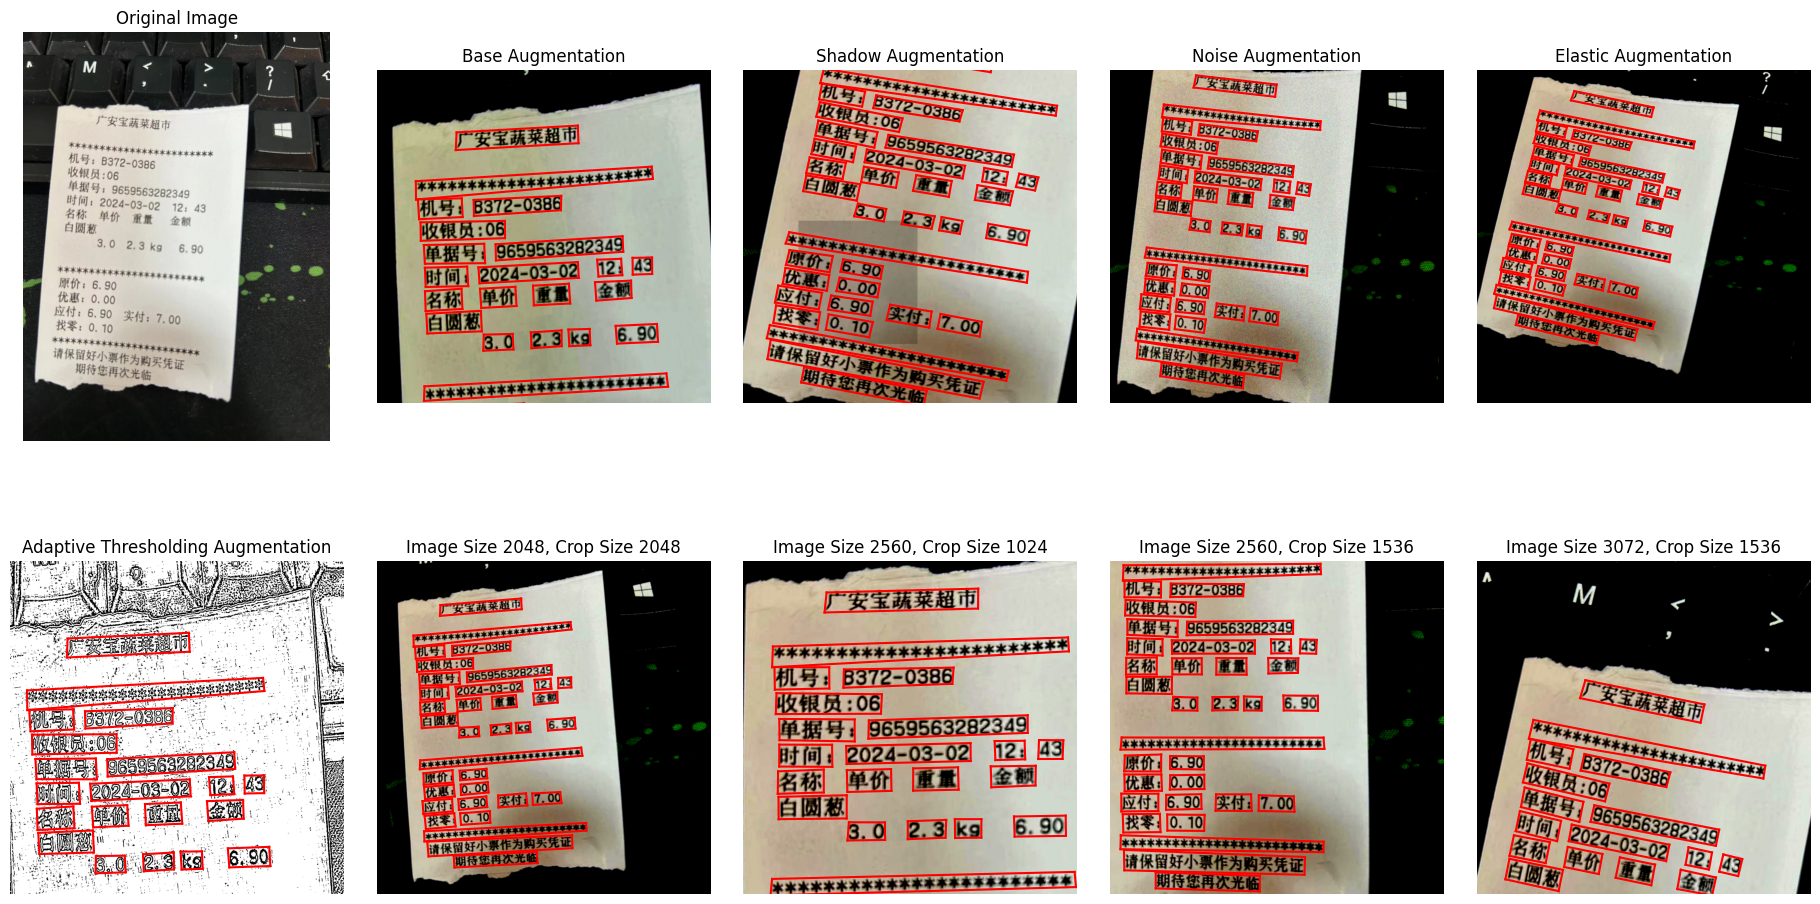

In [10]:
import numpy as np
import albumentations as A
import cv2

# Load and access JSON data correctly
base_path = "../code/data/chinese_receipt"
with open(f"{base_path}/ufo/train.json", 'r', encoding='utf-8') as file:
    data = json.load(file)
    
# Get the first image name and data
first_image = list(data['images'].items())[0]  # Get first image entry
image_name = first_image[0]  # Get image name
image_data = first_image[1]  # Get image data
words = image_data['words'].values() # Get words data

aug = []
original, base, base_ver = apply_image(image_name, words, 2048, 1024, aug, True)

aug = [   
    RectangleShadowTransform(
        opacity_range=(0.7, 0.9),
        width_range=(0.25, 0.5),
        height_range=(0.25, 0.5),
        p=1.0
    )
]
_, shadow, shadow_ver = apply_image(image_name, words, 2048, 1024, aug, False)

aug = [   
    A.GaussNoise(var_limit=(0.01, 0.05), p=0.4),
    A.MultiplicativeNoise(multiplier=(0.9, 1.5), p=0.4)
]
_, noise, noise_ver = apply_image(image_name, words, 2048, 2048, aug, False)

aug = [   
    A.ElasticTransform(alpha=1000, sigma=50, p=0.5)
]
_, elastic, elastic_ver = apply_image(image_name, words, 2048, 2048, aug, False)

aug = [   
    CustomAdaptiveThreshold(
        block_size=11,  # 필요에 따라 조정
        c=2,           # 필요에 따라 조정
        p=1.0
    )
]
_, adaptive, adaptive_ver = apply_image(image_name, words, 2048, 1024, aug, False)

aug = []
_, image2048, vertices2048 = apply_image(image_name, words, 2048, 2048, aug, False)
_, image2560_1, vertices1024 = apply_image(image_name, words, 2560, 1024, aug, False)
_, image2560_2, vertices1536_2 = apply_image(image_name, words, 2560, 1536, aug, False)
_, image3072, vertices1536_3 = apply_image(image_name, words, 3072, 1536, aug, False)

# 기존 코드에서 figure 생성 부분과 타이틀 설정 부분만 수정
fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # figsize를 더 크게 설정

# 전체 figure에 대한 여백 조정
plt.subplots_adjust(
    top=0.95,      # 상단 여백 줄이기 (1에 가까울수록 위로)
    bottom=0.05,   # 하단 여백 줄이기 (0에 가까울수록 아래로)
    left=0.05,     # 왼쪽 여백
    right=0.95,    # 오른쪽 여백
    hspace=0.2,    # 서브플롯 간 세로 간격
    wspace=0.1     # 서브플롯 간 가로 간격
)
        
axs[0, 0].set_title('Original Image')
axs[0, 0].imshow(original)
axs[0, 0].axis('off')

axs[0, 1].set_title('Base Augmentation')
draw_bbox(axs[0, 1], base_ver)
axs[0, 1].imshow(base)
axs[0, 1].axis('off')

axs[0, 2].set_title('Shadow Augmentation')
draw_bbox(axs[0, 2], shadow_ver)
axs[0, 2].imshow(shadow)
axs[0, 2].axis('off')

axs[0, 3].set_title('Noise Augmentation')
draw_bbox(axs[0, 3], noise_ver)
axs[0, 3].imshow(noise)
axs[0, 3].axis('off')

axs[0, 4].set_title('Elastic Augmentation')
draw_bbox(axs[0, 4], elastic_ver)
axs[0, 4].imshow(elastic)
axs[0, 4].axis('off')

axs[1, 0].set_title('Adaptive Thresholding Augmentation')
draw_bbox(axs[1, 0], adaptive_ver)
axs[1, 0].imshow(adaptive)
axs[1, 0].axis('off')

axs[1, 1].set_title('Image Size 2048, Crop Size 2048')
draw_bbox(axs[1, 1], vertices2048)
axs[1, 1].imshow(image2048)
axs[1, 1].axis('off')

axs[1, 2].set_title('Image Size 2560, Crop Size 1024')
draw_bbox(axs[1, 2], vertices1024)
axs[1, 2].imshow(image2560_1)
axs[1, 2].axis('off')

axs[1, 3].set_title('Image Size 2560, Crop Size 1536')
draw_bbox(axs[1, 3], vertices1536_2)
axs[1, 3].imshow(image2560_2)
axs[1, 3].axis('off')

axs[1, 4].set_title('Image Size 3072, Crop Size 1536')
draw_bbox(axs[1, 4], vertices1536_3)
axs[1, 4].imshow(image3072)
axs[1, 4].axis('off')
plt.show()